In [1]:
#include "TFile.h"
#include "TTree.h"
#include "TBrowser.h"
#include "TH2.h"
#include "TRandom.h"
#include "TCanvas.h"
#include "TMath.h"
#include "TROOT.h"
#include <string>
#include <iostream>
#include "TTreeReader.h"

//#include "../test/Event.h"

In [2]:
//TDRStyle
gSystem->Load("style-CMSTDR.C");

In [3]:
int CreateRandomTree(std::string name)
{
    gROOT->Reset();
    /*
    Create Ttrees for tries 
    */
    std::string Name = name+".root";
    //convierto en cadena de caracteres constante (es lo que recibe la función)
    const char * constName = Name.c_str();
    //const char * constname = name.c_str();
    TFile hfile(constName,"RECREATE");
    //The Ttrees must to have the same name "tree" in this case, "Delphes"
    TTree *T = new TTree("tree","test Ttree");
    Double_t px,py,pz;
    UShort_t i;
    T->Branch("px",&px,"px/D");
    T->Branch("py",&py,"py/D");
    T->Branch("pz",&pz,"pz/D");
    T->Branch("i",&i,"i/s");
    for (i = 0; i < 65000; i++) {
        px = (Double_t) gRandom->Binomial(500,0.05);
        pz = (Double_t) gRandom->Landau(-10,100);
        py = (Double_t) gRandom->Gaus(0,1000);
        T->Fill();
    }

    //T->Print();
    hfile.Write();
    hfile.Close();
   return 0;
}

In [4]:
//CreateRandomTree("tree1");
//CreateRandomTree("tree2");

In [5]:
TChain * chain1 = new TChain("tree");
TChain * chain2 = new TChain("tree");
chain1->Add("tree1.root");
chain1->Add("tree2.root");
chain2->Add("tree3.root");
chain2->Add("tree4.root");

In [6]:
//chain1->Print()

In [7]:
//tree->Show(120000)

In [8]:
//chain1->GetEntries()

In [9]:
//   Specify address where to read the event object
//   In the program writing the files, the event was stored in a branch called "py,px,pz, and i"
Double_t py;
Double_t px;
Double_t pz;
UShort_t i;

In [10]:
chain1->SetBranchAddress("px", &px);
chain1->SetBranchAddress("py", &py);
chain1->SetBranchAddress("pz", &pz);
chain1->SetBranchAddress("i", &i);

In [11]:
//chain1->SetBranchStatus("*", 0); /*Todas las ramas out*/
//chain1->SetBranchStatus("px", 1);   

In [12]:
//   Create an histogram
TH1F *Pxst = new TH1F();
Pxst->SetName("Px");
Pxst->SetTitle("Histograma de Px");
Pxst->SetFillColor(1);

TH1F *Pyst = new TH1F();
Pxst->SetName("Py");
Pxst->SetTitle("Histograma de Py");
Pxst->SetFillColor(2);

TH1F *Pzst = new TH1F();
Pxst->SetName("Pz");
Pxst->SetTitle("Histograma de Pz");
Pxst->SetFillColor(4);

In [13]:
Int_t n =chain1->GetEntries();
for (Int_t j=0;j<n;j++) {
    chain1->GetEvent(j);              //read complete accepted event in memory
    Pxst->Fill(px);              //Fill histogram with 
    Pyst->Fill(py);
    Pzst->Fill(pz);    
}

In [21]:
THStack *hs = new THStack();

input_line_110:2:11: error: redefinition of 'hs'
 THStack *hs = new THStack();
          ^
input_line_76:2:11: note: previous definition is here
 THStack *hs = new THStack("hs","Stacked 1D histograms");
          ^


In [15]:
hs->Add(Pxst);
hs->Add(Pyst);
hs->Add(Pzst);

In [16]:
TCanvas *cst = new TCanvas();
cst->Divide(2,2);

In [17]:
cst->cd(1);
hs->Draw();

In [18]:
cst->cd(2);
gPad->SetGrid();
hs->Draw("nostack,e1p");

In [19]:
cst->cd(3);
gPad->SetFrameFillColor(17);
gPad->SetTheta(3.77);
gPad->SetPhi(2.9);
hs->Draw("lego1");

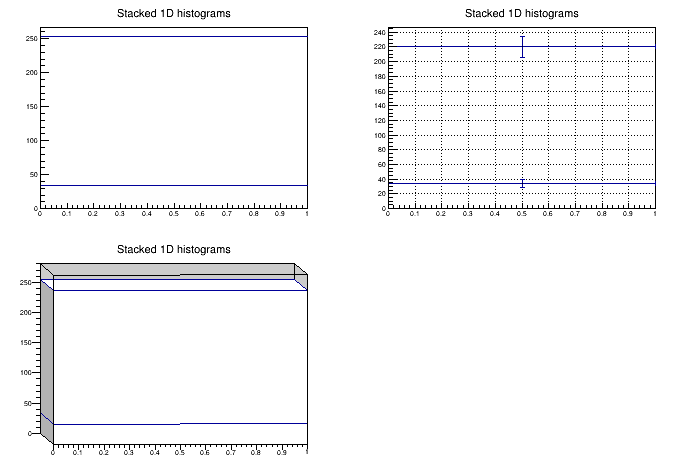

In [20]:
gROOT->GetListOfCanvases()->Draw()